In [25]:
import torch  
from torch.utils.data import Dataset, DataLoader  
from torch.utils.data import random_split, DataLoader  
import torchvision.transforms as transforms  
from torchvision.datasets import ImageFolder  
from PIL import Image  
import pathlib  
import cupy as cp 
from torchvision.datasets import ImageFolder
from torchvision import datasets
import torch  
import torch.nn as nn  
import torch.optim as optim  
from PIL import Image

In [26]:
# Verificar la disponibilidad de la GPU  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print("GPU disponible:", torch.cuda.is_available())
print("Nombre de la GPU:", torch.cuda.get_device_name() if torch.cuda.is_available() else "N/A")


GPU disponible: True
Nombre de la GPU: NVIDIA GeForce RTX 4060


In [27]:
# Definir directorios
directorio_dataset = '../Datasets/CIFAR-10 dos clases'
imagenes_originales = '../Datasets/CIFAR-10 dos clases/cat'
imagenes_corruptas = '../Datasets/CIFAR-10 dos clases/cat_c_defocus_blur'

directorio_dataset = pathlib.Path(directorio_dataset)
imagenes_originales = pathlib.Path(imagenes_originales)
imagenes_corruptas = pathlib.Path(imagenes_corruptas)

# Images dimensions
img_height = 32
img_width = 32
channels = 3
batch_size = 32

# Transformaciones para preprocesamiento de datos
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),  # Ajustar tamaño a 32x32
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizar
])

class CustomImageDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = pathlib.Path(directory)
        self.transform = transform
        self.images = list(self.directory.glob('*.png'))

    def __len__(self):  
        return len(self.images)  

    def __getitem__(self, idx):  
        img_path = self.images[idx]  
        image = Image.open(img_path).convert('RGB')  
        if self.transform:  
            image = self.transform(image)  
        return image

# Crear datasets personalizados
dataset_completo = datasets.ImageFolder(root=str(directorio_dataset), transform=transform)

# Calcular total
total_dataset = len(list(directorio_dataset.glob('*/*.png')))



# Calculo de los tamaños para entrenamiento (80%) y validación (20%)  
train_size = int(0.8 * total_dataset)  
val_size = total_dataset - train_size 

# Random split del dataset  
train_dataset, val_dataset = random_split(dataset_completo, [train_size, val_size])  

# Crear el DataLoader para iterar sobre los datos 
dataloader_completo = DataLoader(dataset_completo, batch_size=batch_size, shuffle=False, num_workers=0)


print(f"Total imágenes dataset: {total_dataset}")  
print(f'Tamaño del conjunto de entrenamiento: {len(train_dataset)}')  
print(f'Tamaño del conjunto de validación: {len(val_dataset)}')

# Get the class names
class_names = dataset_completo.classes
num_classes = len(class_names)

print(f"Número de clases: {num_classes}")
print(f"Los nombres de las clases son: {class_names}")


Total imágenes dataset: 10000
Tamaño del conjunto de entrenamiento: 8000
Tamaño del conjunto de validación: 2000
Número de clases: 2
Los nombres de las clases son: ['cat', 'cat_c_defocus_blur']


In [28]:
# Crear el DataLoader para iterar sobre el dataset completo   
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)  
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)  

In [29]:

# Definir el modelo de clasificación multiclase  
class MulticlassCNN(nn.Module):  
    def __init__(self, num_classes=2):  
        super(MulticlassCNN, self).__init__()  
        self.conv1 = nn.Conv2d(channels, 16, kernel_size=3, stride=1, padding=1)  
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  
        self.fc1 = nn.Linear(32 * 8 * 8, 128)  
        self.fc2 = nn.Linear(128, num_classes)  
        self.relu = nn.ReLU()  

    def forward(self, x):  
        x = self.pool(self.relu(self.conv1(x)))  
        x = self.pool(self.relu(self.conv2(x)))  
        x = x.view(-1, 32 * 8 * 8)  
        x = self.relu(self.fc1(x))  
        x = self.fc2(x)  
        return x  

# Instanciar el modelo  
model = MulticlassCNN(num_classes=num_classes).to(device)  


# Definir la función de pérdida y el optimizador  
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)  


# Definir bucle de entrenamiento  
num_epochs = 4  
train_losses = []  
val_losses = []  
train_accuracies = []  
val_accuracies = []  

for epoch in range(num_epochs):  
    model.train()  
    running_loss = 0.0  
    correct = 0  
    total = 0  

    for images, labels in train_loader:  
        images, labels = images.to(device), labels.to(device)  
        outputs = model(images)  
        loss = criterion(outputs, labels)  

        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()  

        running_loss += loss.item()   # Actualizar estadísticas 
        _, predicted = torch.max(outputs, 1)  # Calcular precisión
        total += labels.size(0)  
        correct += (predicted == labels).sum().item()  

    epoch_loss = running_loss / len(train_loader)  
    accuracy = 100 * correct / total  
    train_losses.append(epoch_loss)  
    train_accuracies.append(accuracy)  

    # Validación  
    model.eval()  
    val_running_loss = 0.0  
    val_correct = 0  
    val_total = 0  

    with torch.no_grad():  
        for images, labels in val_loader:  
            images, labels = images.to(device), labels.to(device)  
            outputs = model(images)  
            loss = criterion(outputs, labels)  
            val_running_loss += loss.item()  
            _, predicted = torch.max(outputs, 1)  
            val_total += labels.size(0)  
            val_correct += (predicted == labels).sum().item()  

    val_loss = val_running_loss / len(val_loader)  
    val_accuracy = 100 * val_correct / val_total  
    val_losses.append(val_loss)  
    val_accuracies.append(val_accuracy)  

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")  

print("Entrenamiento completado")

Epoch [1/4], Loss: 0.5676, Accuracy: 69.78%, Val Loss: 0.4513, Val Accuracy: 79.80%
Epoch [2/4], Loss: 0.4248, Accuracy: 80.83%, Val Loss: 0.3966, Val Accuracy: 82.50%
Epoch [3/4], Loss: 0.3883, Accuracy: 82.35%, Val Loss: 0.3732, Val Accuracy: 83.70%
Epoch [4/4], Loss: 0.3478, Accuracy: 84.46%, Val Loss: 0.3439, Val Accuracy: 84.95%
Entrenamiento completado


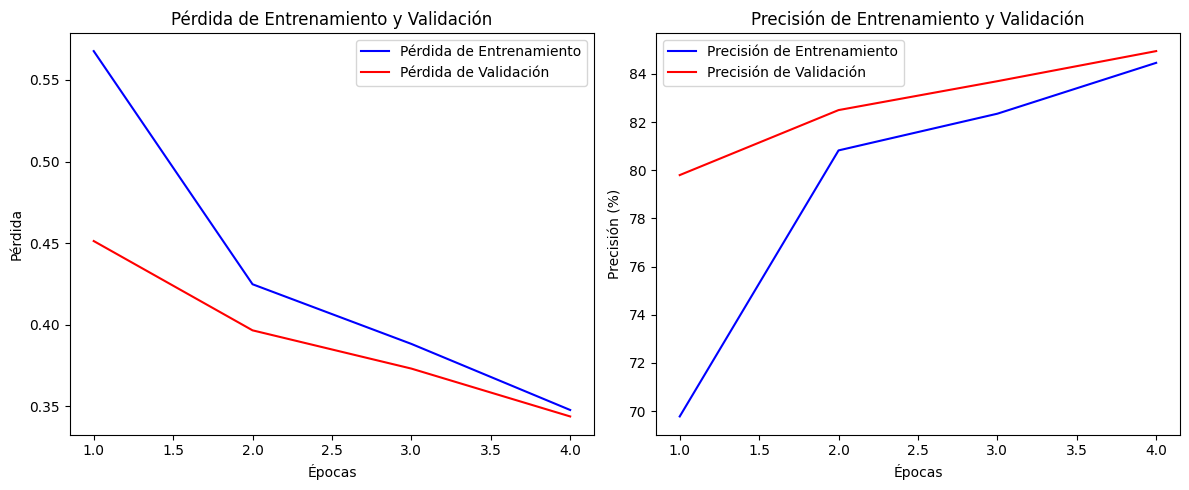

In [30]:
import matplotlib.pyplot as plt  

epochs = range(1, num_epochs + 1)  

plt.figure(figsize=(12, 5))  

# Graficar la pérdida  
plt.subplot(1, 2, 1)  
plt.plot(epochs, train_losses, 'b-', label='Pérdida de Entrenamiento')  
plt.plot(epochs, val_losses, 'r-', label='Pérdida de Validación')  
plt.xlabel('Épocas')  
plt.ylabel('Pérdida')  
plt.title('Pérdida de Entrenamiento y Validación')  
plt.legend()  

# Graficar la precisión  
plt.subplot(1, 2, 2)  
plt.plot(epochs, train_accuracies, 'b-', label='Precisión de Entrenamiento')  
plt.plot(epochs, val_accuracies, 'r-', label='Precisión de Validación')  
plt.xlabel('Épocas')  
plt.ylabel('Precisión (%)')  
plt.title('Precisión de Entrenamiento y Validación')  
plt.legend()  

plt.tight_layout()  
plt.show()

In [31]:
# Obtener predicciones

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support  
import numpy as np

# Evaluación del modelo  
model.eval()  

all_labels = []  
all_predictions = []

with torch.no_grad():  
    for images, labels in val_loader:  
        images, labels = images.to(device), labels.to(device)  
        outputs = model(images)  
        
        _, predicted = torch.max(outputs, 1)  
        all_labels.extend(labels.cpu().numpy())  
        all_predictions.extend(predicted.cpu().numpy())  

# Convertir listas a arrays para usar en scikit-learn  
all_labels = np.array(all_labels)  
all_predictions = np.array(all_predictions)  

In [32]:
# Presicion, recall y F1 score

from sklearn.metrics import precision_recall_fscore_support  

# Calcular precisión, recall, F1-score  
precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, average=None)  

# Mostrar resultados  
for class_name, prec, rec, f1 in zip(class_names, precision, recall, f1_score):  
    print(f"Class: {class_name} - Precision: {prec:.2f}, Recall: {rec:.2f}, F1 Score: {f1:.2f}")  

# Para obtener los promedios:  
average_precision, average_recall, average_f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')  
print(f"Weighted Average Precision: {average_precision:.2f}")  
print(f"Weighted Average Recall: {average_recall:.2f}")  
print(f"Weighted Average F1 Score: {average_f1_score:.2f}") 

Class: cat - Precision: 0.81, Recall: 0.91, F1 Score: 0.86
Class: cat_c_defocus_blur - Precision: 0.90, Recall: 0.79, F1 Score: 0.84
Weighted Average Precision: 0.85
Weighted Average Recall: 0.85
Weighted Average F1 Score: 0.85


In [33]:
for i, (image, label) in enumerate(val_loader):  
    image, label = image.to(device), label.to(device)  
    output = model(image)  
    _, predicted = torch.max(output, 1)  
    # Imprime algunas predicciones y etiquetas reales  
    if i < 5:  # Limita a las primeras 5 iteraciones   
        print(f"Etiqueta Real: {label.cpu().numpy()}, Predicción: {predicted.cpu().numpy()}") 

Etiqueta Real: [1 1 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 1 0 1 1 0 0 1 1 0 1 0 0], Predicción: [1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0]
Etiqueta Real: [0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 1 1 0 1 0 1 1 1 0 0 1 1 0 1 0], Predicción: [0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1 0 1 0]
Etiqueta Real: [1 0 0 1 0 1 0 1 1 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 0 0 0 1], Predicción: [0 0 0 1 1 1 0 1 0 0 0 1 1 1 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0]
Etiqueta Real: [0 1 1 1 0 0 0 1 0 0 0 1 1 0 1 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 1 0], Predicción: [0 0 1 1 1 0 0 0 0 0 0 1 1 0 1 1 1 0 0 1 0 0 0 1 1 0 1 0 0 0 1 0]
Etiqueta Real: [1 1 0 1 0 1 1 1 1 0 1 0 1 0 1 1 0 0 1 0 0 1 1 0 1 0 1 1 1 1 0 1], Predicción: [1 1 0 1 0 1 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 1 1 0 1 0 1 1 1 0 0 1]


Matriz de Confusión:
[[927  90]
 [211 772]]


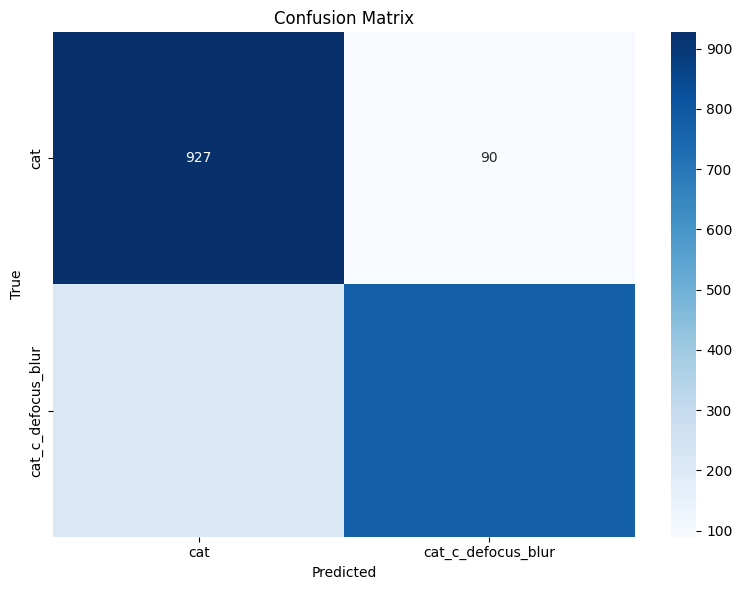

In [34]:
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.metrics import confusion_matrix  

# Calcular la matriz de confusión  
cm = confusion_matrix(all_labels, all_predictions)  

# Verificar la matriz de confusión  
print("Matriz de Confusión:")  
print(cm)  

# Visualizar la matriz de confusión  
plt.figure(figsize=(8, 6))  
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)  
plt.xlabel('Predicted')  
plt.ylabel('True')  
plt.title('Confusion Matrix')  
plt.tight_layout()  # Asegura que todo el contenido se ajuste dentro de la figura  
plt.show()